In [1]:
import os

if (os.path.basename(os.getcwd()) == 'Notebooks'):
    os.chdir('..')
    
os.getcwd()

'c:\\Users\\sebastian\\SynologyDrive\\Studium\\10.Semester\\Wettbewerb\\project\\code\\KISMED'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from ecgdetectors import Detectors
import scipy.fftpack
import seaborn as sns

from wettbewerb import load_references
from preprocessing.features import*
from preprocessing.preprocessing import*
from preprocessing.padding import *


# Time and Frequency Analysis 02 (Beat based)

## Needed Methods

### Preprocessing

In [91]:
# def compute_FFT(signal, fs=300):

#     spectrum = scipy.fftpack.fft(signal)
#     spectrum = 2/len(signal)*np.abs(spectrum[:len(signal)//2])
#     freq = np.linspace(0.0, fs/2.0, len(signal)//2)  # want only too see the first half -> periodicity

#     return (freq, spectrum)

# # freq, spectrum = compute_FFT(ecg_leads_af[0])
# # plt.plot(freq, spectrum)
# # plt.show()

# def compute_PSD(signal, fs=300):
#     spectrum = np.fft.fft(signal)
#     factor = 2.0/(len(spectrum)*len(spectrum))
#     power = factor*(spectrum.real**2+spectrum.imag**2)
#     freq = np.fft.fftfreq(len(signal), 1/fs)

#     freq = freq[0:int(len(ecg_leads_af[0])/2)]
#     power = power[0:int(len(ecg_leads_af[0])/2)]

#     return (freq, power)

# # freq, power = compute_PSD(ecg_leads_af[0], fs=300)
# # freq, power = signal.periodogram(ecg_leads_af[0], 300)
# # plt.plot(freq, power)
# # plt.show()

# def compute_Band_Power(signal, lb, ub, psd=False, fs=300):

#     if not psd:
#         ecg_freq, ecg_abs = compute_FFT(signal, fs)
#         mask = np.logical_and((ecg_freq>lb), (ecg_freq<=ub))
#         band_power = np.sum(ecg_abs[mask]**2)/np.sum(ecg_abs**2)

#     else:
#         ecg_freq, ecg_abs = compute_PSD(signal, fs)
#         mask = np.logical_and((ecg_freq>lb), (ecg_freq<=ub))
#         band_power = np.sum(ecg_abs[mask])/np.sum(ecg_abs)

#     return band_power

# def compute_beat_fib_power(ecg_lead, fs, invert=False, psd=False):
#     inv_tmp = ecg_lead
#     if invert:
#         inv_tmp = invert2(ecg_lead)

#     beats = divide_heartbeats(inv_tmp, fs=fs)
    
#     all_fib_powers = []
#     for b in beats:
#         fib_power = compute_Band_Power(b, lb=3.8, ub=8, psd=psd)
#         all_fib_powers.append(fib_power)
    
#     return all_fib_powers


# def max_beat_fib_power(ecg, fs, invert=True, psd=False, calib_th=1):
#     beat_fib_power = compute_beat_fib_power(ecg, fs, invert=invert, psd=psd)
    
#     if len(beat_fib_power) < 2*calib_th:
#         print('Could not use given calibration threshold')
#         return np.max(beat_fib_power)

#     return np.max(beat_fib_power[calib_th:-calib_th])

### Plotutils

In [4]:
# PLOT-METHODS

def plot_ecg(ecg_lead, detectors, time_span=np.NaN, freq_span=np.NaN, r_rate=False, fs=300):
    if np.isnan(time_span):  # in seconds
        time_span = (0, len(ecg_lead)/fs)
    if np.isnan(freq_span):
        freq_span = (0, fs/2.0)  # in Hz

    # FFT
    freq, spectrum = compute_FFT(ecg_lead, fs)

    # time 
    time_arr = np.linspace(0, len(ecg_lead)/fs, len(ecg_lead))

    # plot
    fig, axs = plt.subplots(2,1, constrained_layout=True)

    # time domain
    axs[0].scatter(time_arr, ecg_lead, s=1)
    axs[0].set_xlim(*time_span)
    axs[0].set_title("ECG - Time domain")
    axs[0].set_xlabel("time [s]")
    axs[0].set_ylabel("Voltage [mV]")
   
    # frequency domain
    axs[1].plot(freq, spectrum)
    axs[1].set_xlim(*freq_span)
    axs[1].set_title("ECG - FFT")
    axs[1].set_xlabel("Frequenzy [Hz]")
    axs[1].set_ylabel("Voltage [mV]")

    # R-Peak rate
    if r_rate:
        r_peaks = detectors.engzee_detector(ecg_lead)  # TODO: algorithms vary in the resuls 
        r_rate = len(r_peaks)/(len(ecg_lead)/fs)
        axs[0].scatter(time_arr[r_peaks], ecg_lead[r_peaks], s=10, label='R_peaks')
        axs[1].axvline(x=r_rate, color='r', label='R_rate')        

        axs[0].legend(loc="best")
        axs[1].legend(loc="best")

    plt.show()

# Test method
# fs = 300
# detectors = Detectors(fs)
# plot_ecg(ecg_leads_af[0], detectors, time_span=np.NaN, freq_span=np.NaN, r_rate=True, fs=300);
# #plot_ecg(ecg_leads_af[0], detectors)

def plot_heartbeat(ecg_lead, detectors, beat_id=0, fs=300):
    beats = divide_heartbeats(ecg_lead, fs)
    plot_ecg(beats[beat_id], detectors, fs=fs)



## Load the ECGs

In [5]:
ecg_leads, ecg_labels, fs, ecg_names = load_references(folder="data/training")

6000	 Dateien wurden geladen.


### Select only ECGs of the category Atrial Fibrilation (A) and Normal (N)

In [6]:
# get ids for ECGs from category AF and N
af_ids = np.where(np.array(ecg_labels)=='A')[0]
n_ids = np.where(np.array(ecg_labels)=='N')[0]

# get only ecgs from category AF and N
ecg_leads_n = np.array(ecg_leads, dtype=object)[n_ids]
ecg_leads_af = np.array(ecg_leads, dtype=object)[af_ids]

# Inspection of single heartbeats

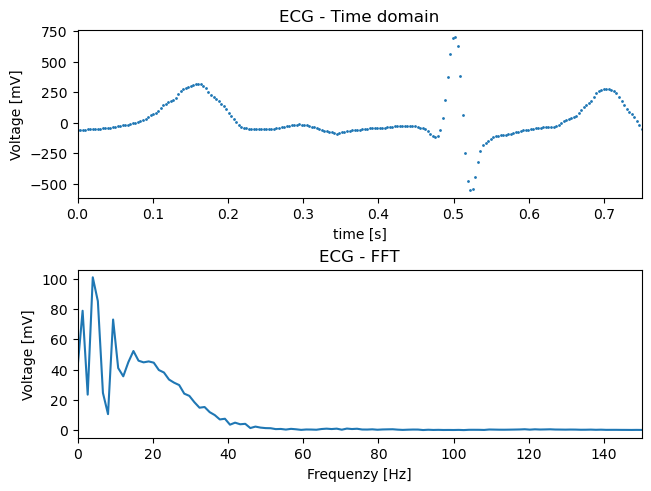

In [7]:
detectors = Detectors(fs)
plot_heartbeat(ecg_leads_af[1], detectors, beat_id=5, fs=300)

### Inspecting heartbeats at fibrillation frequency band (3.8-8Hz)

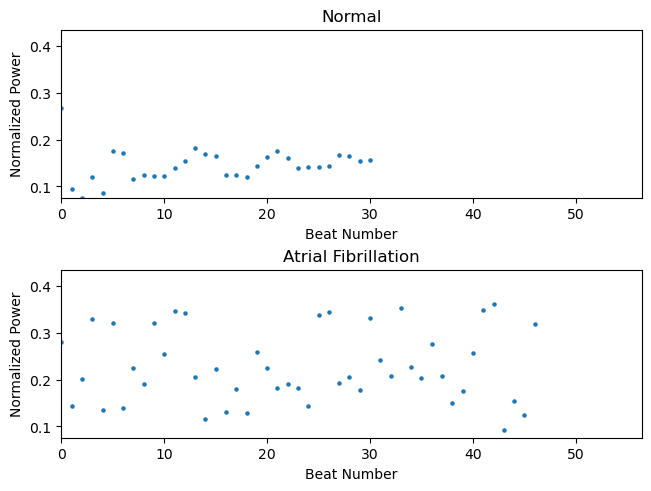

In [8]:
# Example
example_id = 1
psd = False

# compute the fibrillation powers over all beats
power_band_n = compute_beat_fib_power(ecg_leads_n[example_id], fs)
power_band_af = compute_beat_fib_power(ecg_leads_af[example_id], fs)

# PLOT
fig, axs = plt.subplots(2,1, constrained_layout=True)

# normal ecg
axs[0].scatter(range(0, len(power_band_n)), power_band_n, s=5)
axs[0].set_title("Normal")
axs[0].set_xlabel("Beat Number")
axs[0].set_ylabel("Normalized Power")

# afib ecg
axs[1].scatter(range(len(power_band_af)), power_band_af, s=5)
axs[1].set_title("Atrial Fibrillation")
axs[1].set_xlabel("Beat Number")
axs[1].set_ylabel("Normalized Power")

plt.setp(axs, xlim=(0, 1.2*np.max([len(power_band_n), len(power_band_af)])), ylim=(np.min([*power_band_n, *power_band_af]), 1.2*np.max([*power_band_n, *power_band_af])))
plt.show()

### Computing std. of the normalized power for each beat on each ECG 

In [9]:
ecg_leads_n_beats_std = []
for ecg in ecg_leads_n:
    beat_fib_power = compute_beat_fib_power(ecg, fs, invert=True)
    if len(beat_fib_power) != 0:
        ecg_leads_n_beats_std.append(np.std(beat_fib_power))
    else:
        print('No beat power computable')
        #ecg_leads_n_beats_std.append(-1)

ecg_leads_af_beats_std = []
for ecg in ecg_leads_af:
    beat_fib_power = compute_beat_fib_power(ecg, fs, invert=True)
    if len(beat_fib_power) != 0:
        ecg_leads_af_beats_std.append(np.std(beat_fib_power))
    else:
        print('No beat power computable')
        #ecg_leads_af_beats_std.append(-1)

c:\Users\sebastian\SynologyDrive\Studium\10.Semester\Wettbewerb\project\code\KISMED\preprocessing\preprocessing.py:60: RuntimeWarning: Mean of empty slice.
  orig_peaks_mean = orig_sinal_peaks.mean()
c:\Users\sebastian\anaconda3\envs\AFDet\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


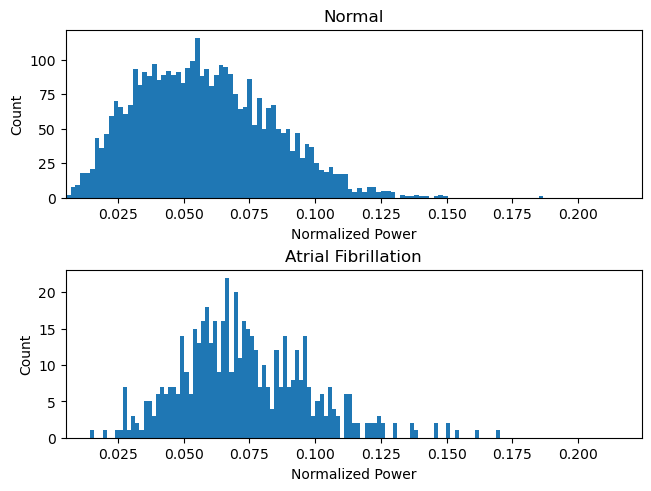

In [10]:
nmbr_bins = 100

fig, axs = plt.subplots(2,1, constrained_layout=True)

axs[0].hist(ecg_leads_n_beats_std,nmbr_bins)
axs[0].set_title("Normal")
axs[0].set_xlabel("Normalized Power")
axs[0].set_ylabel("Count")

axs[1].hist(ecg_leads_af_beats_std,nmbr_bins)
axs[1].set_title("Atrial Fibrillation")
axs[1].set_xlabel("Normalized Power")
axs[1].set_ylabel("Count")

plt.setp(axs, xlim=(np.min([*ecg_leads_n_beats_std, *ecg_leads_af_beats_std]), 1.2*np.max([*ecg_leads_n_beats_std, *ecg_leads_af_beats_std])))

plt.show()

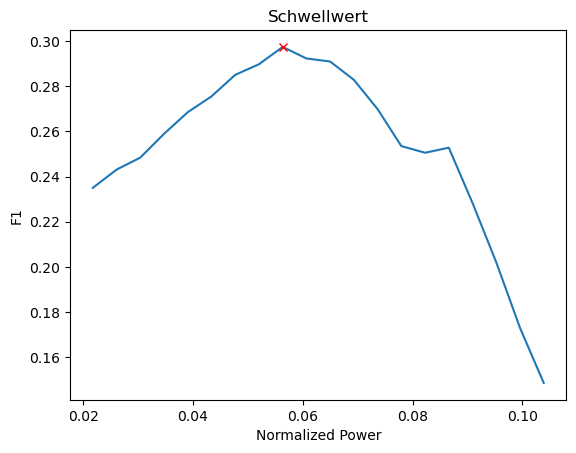

F1-score: 0.2974588938714499


In [11]:
beats_max_total = np.append(ecg_leads_n_beats_std,ecg_leads_af_beats_std) # Kombination der beiden SDNN-Listen
p05 = np.nanpercentile(beats_max_total,5)          # untere Schwelle
p95 = np.nanpercentile(beats_max_total,95)         # obere Schwelle
thresholds = np.linspace(p05, p95, num=20)    # Liste aller möglichen Schwellwerte
F1 = np.array([])
for th in thresholds:
  TP = np.sum(ecg_leads_af_beats_std>=th)                  # Richtig Positiv
  TN = np.sum(ecg_leads_n_beats_std<th)                 # Richtig Negativ
  FP = np.sum(ecg_leads_n_beats_std>=th)                # Falsch Positiv
  FN = np.sum(ecg_leads_af_beats_std<th)                   # Falsch Negativ
  F1 = np.append(F1, TP / (TP + 1/2*(FP+FN))) # Berechnung des F1-Scores

th_opt=thresholds[np.argmax(F1)]              # Bestimmung des Schwellwertes mit dem höchsten F1-Score

fig, ax = plt.subplots()
ax.plot(thresholds,F1)
ax.plot(th_opt,F1[np.argmax(F1)],'xr')
ax.set_title("Schwellwert")
ax.set_xlabel("Normalized Power")
ax.set_ylabel("F1")
plt.show()

print('F1-score:', np.max(F1))

### Compute max. normalized power of a heartbeat in each ECG

In [13]:
BOL_INVERT = True
POW_PSD = False
CALIB_TH = 1


ecg_leads_n_beats_max = []
for ecg in ecg_leads_n:
    max_beat_fib_pow = max_beat_fib_power(ecg, fs=300, invert=BOL_INVERT, psd=POW_PSD, calib_th=CALIB_TH)
    ecg_leads_n_beats_max.append(max_beat_fib_pow)


ecg_leads_af_beats_max = []
for ecg in ecg_leads_af:
    max_beat_fib_pow = max_beat_fib_power(ecg, fs=300, invert=BOL_INVERT, psd=POW_PSD, calib_th=CALIB_TH)
    ecg_leads_af_beats_max.append(max_beat_fib_pow)

# further use only sucessful computations, i.e. not -1
ecg_leads_n_beats_max = np.array(ecg_leads_n_beats_max)[np.array(ecg_leads_n_beats_max)>=0]
ecg_leads_af_beats_max = np.array(ecg_leads_af_beats_max)[np.array(ecg_leads_af_beats_max)>=0]

c:\Users\sebastian\SynologyDrive\Studium\10.Semester\Wettbewerb\project\code\KISMED\preprocessing\preprocessing.py:60: RuntimeWarning: Mean of empty slice.
  orig_peaks_mean = orig_sinal_peaks.mean()
c:\Users\sebastian\anaconda3\envs\AFDet\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


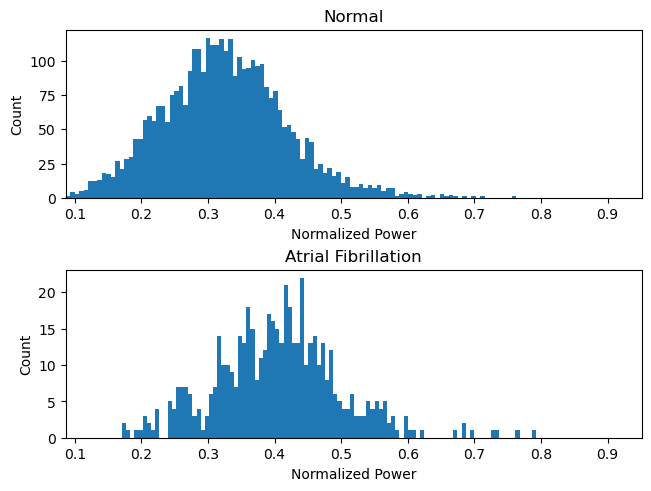

In [14]:
nmbr_bins = 100

fig, axs = plt.subplots(2,1, constrained_layout=True)
axs[0].hist(ecg_leads_n_beats_max,nmbr_bins)
axs[0].set_xlim([0, 0.8])
axs[0].set_title("Normal")
axs[0].set_xlabel("Normalized Power")
axs[0].set_ylabel("Count")

axs[1].hist(ecg_leads_af_beats_max,nmbr_bins)
axs[1].set_xlim([0, 0.8])
axs[1].set_title("Atrial Fibrillation")
axs[1].set_xlabel("Normalized Power")
axs[1].set_ylabel("Count")


plt.setp(axs, xlim=(np.min([*ecg_leads_n_beats_max, *ecg_leads_af_beats_max]), 1.2*np.max([*ecg_leads_n_beats_max, *ecg_leads_af_beats_max])))
#plt.setp(axs, xlim=(0, 1.2*np.max([*ecg_leads_n_beats_max, *ecg_leads_af_beats_max])))

plt.show()

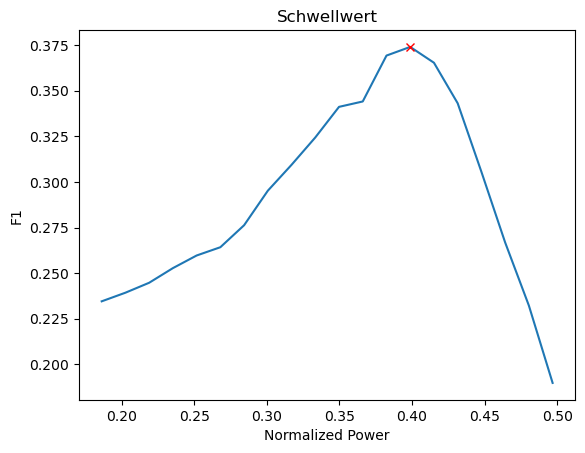

F1-score: 0.3739946380697051


In [15]:
beats_max_total = np.append(ecg_leads_n_beats_max,ecg_leads_af_beats_max) # Kombination der beiden SDNN-Listen
p05 = np.nanpercentile(beats_max_total,5)          # untere Schwelle
p95 = np.nanpercentile(beats_max_total,95)         # obere Schwelle
thresholds = np.linspace(p05, p95, num=20)    # Liste aller möglichen Schwellwerte
F1 = np.array([])
for th in thresholds:
  TP = np.sum(ecg_leads_af_beats_max>=th)                  # Richtig Positiv
  TN = np.sum(ecg_leads_n_beats_max<th)                 # Richtig Negativ
  FP = np.sum(ecg_leads_n_beats_max>=th)                # Falsch Positiv
  FN = np.sum(ecg_leads_af_beats_max<th)                   # Falsch Negativ
  F1 = np.append(F1, TP / (TP + 1/2*(FP+FN))) # Berechnung des F1-Scores

th_opt=thresholds[np.argmax(F1)]              # Bestimmung des Schwellwertes mit dem höchsten F1-Score

fig, ax = plt.subplots()
ax.plot(thresholds,F1)
ax.plot(th_opt,F1[np.argmax(F1)],'xr')
ax.set_title("Schwellwert")
ax.set_xlabel("Normalized Power")
ax.set_ylabel("F1")
plt.show()

print('F1-score:', np.max(F1))

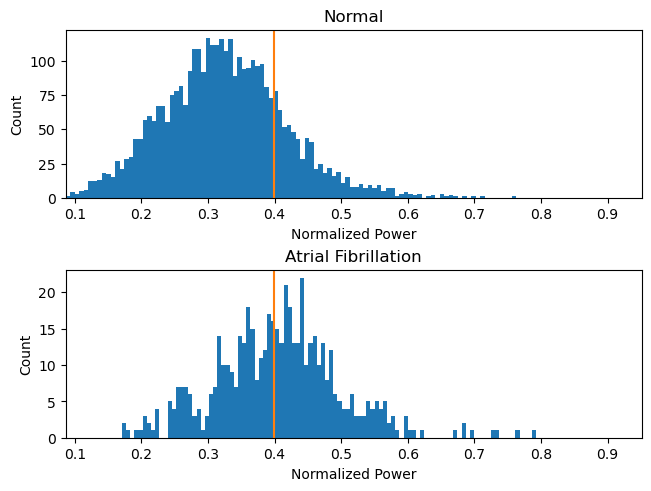

In [16]:
nmbr_bins = 100

fig, axs = plt.subplots(2,1, constrained_layout=True)
axs[0].hist(ecg_leads_n_beats_max,nmbr_bins)
tmp_y = axs[0].get_ylim()
axs[0].plot([th_opt,th_opt],[0,10000])
axs[0].set_ylim(tmp_y)
axs[0].set_title("Normal")
axs[0].set_xlabel("Normalized Power")
axs[0].set_ylabel("Count")

axs[1].hist(ecg_leads_af_beats_max,nmbr_bins)
tmp_y = axs[1].get_ylim()
axs[1].plot([th_opt,th_opt],[0,10000])
axs[1].set_ylim(tmp_y)
axs[1].set_title("Atrial Fibrillation")
axs[1].set_xlabel("Normalized Power")
axs[1].set_ylabel("Count")

plt.setp(axs, xlim=(np.min([*ecg_leads_n_beats_max, *ecg_leads_af_beats_max]), 1.2*np.max([*ecg_leads_n_beats_max, *ecg_leads_af_beats_max])))

plt.show()